# BUDT 758B Project Code
# NLP with Disaster Tweets: Real or Not?
## Group Pig: Li-Hsin Chang, Xinyu Guo, Jingyi Liu, Jiahui Zeng, Gan Zhao, Beilei Zhu

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

https://www.kaggle.com/c/nlp-getting-started/overview

## 1. Importing Libraries

In [1]:
# Use the official tokenization script created by the Google team
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import cluster
from sklearn import manifold

from collections import defaultdict, Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_hub as hub

import transformers as ts
from transformers import BertTokenizer, BertConfig, TFBertModel
import tokenization

ModuleNotFoundError: No module named 'tensorflow_hub'

## 2. Importing Data

In [3]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

# Print the shape of the training data
print('{} rows and {} cols in training dataset.'.format(train.shape[0], train.shape[1]))
print('{} rows and {} cols in training dataset.'.format(test.shape[0], test.shape[1]))

# Inspecting the training data
train.head(10)

7613 rows and 5 cols in training dataset.
3263 rows and 4 cols in training dataset.


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


## 3. Exploratory Data Analysis

### (1) Count of tweets in not disaster and real disaster tweets

0    4342
1    3271
Name: target, dtype: int64

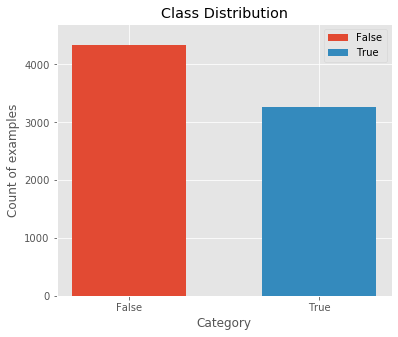

In [4]:
# Frequency for taget variable
count_table = train.target.value_counts()
display(count_table)

# Plot class distribution
plt.figure(figsize=(6,5))
plt.bar('False',count_table[0],label='False',width=0.6)
plt.bar('True', count_table[1],label='True',width=0.6)
plt.legend()
plt.ylabel('Count of examples')
plt.xlabel('Category')
plt.title('Class Distribution')
plt.ylim([0,4700])
plt.show()

### (2) Count of characters in not disaster and disaster tweets 

In [5]:
# Description of characters in 'text'
train['length'] = train['text'].apply(len)
train.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

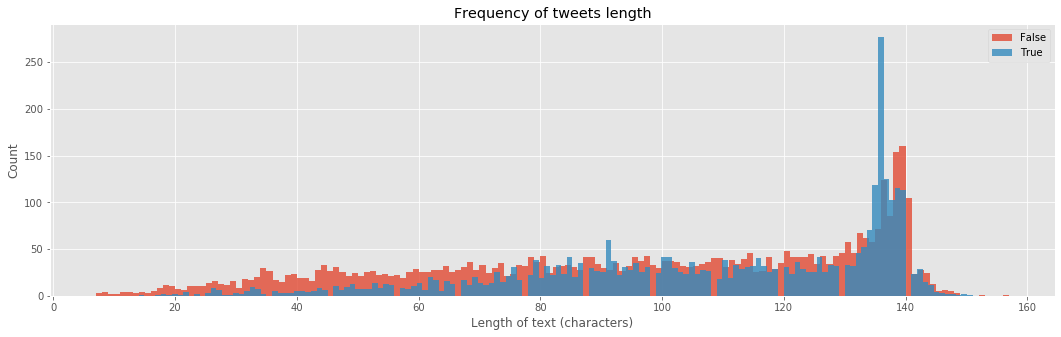

In [6]:
# Plot the frequency of tweets length
bins = 150
plt.figure(figsize=(18,5))
plt.hist(train[train['target']==0]['length'], label= 'False',bins=bins,alpha=0.8)
plt.hist(train[train['target']==1]['length'], label= 'True', bins=bins,alpha=0.8) 
plt.xlabel('Length of text (characters)')
plt.ylabel('Count')
plt.title('Frequency of tweets length')
plt.legend(loc='best')
plt.show()

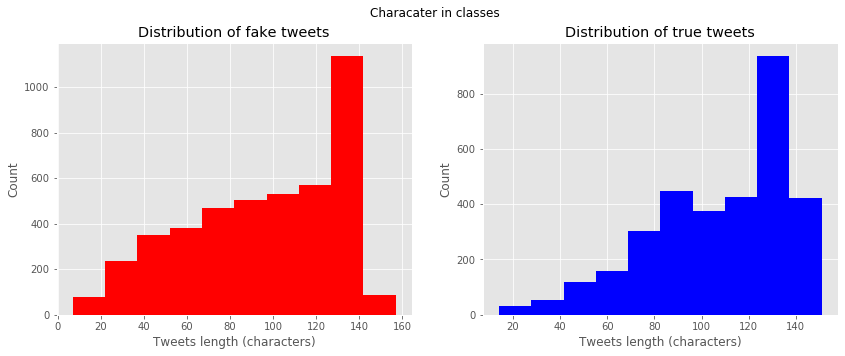

In [7]:
# Frequency of tweets length in 2 classes
fg, (ax1, ax2)=plt.subplots(1,2,figsize=(14,5))
ax1.hist(train[train['target']==0]['length'],color='red')
ax1.set_title('Distribution of fake tweets')
ax1.set_xlabel('Tweets length (characters)')
ax1.set_ylabel('Count')
ax2.hist(train[train['target']==1]['length'],color='blue')
ax2.set_title('Distribution of true tweets')
ax2.set_xlabel('Tweets length (characters)')
ax2.set_ylabel('Count')
fg.suptitle('Characater in classes')
plt.show()

#### Analysis of tweets length in fake or true tweets:
We can see that there is no significant difference of distribution between two classes. They both tend to have many characters and there is a peak in distribution around 140 in both class.

### (3) Count of words in not disaster and disaster tweets 

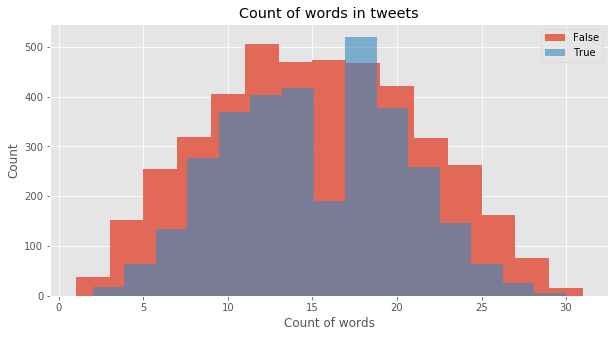

In [8]:
# Plot the distribution of count of words
words_true = train[train['target']==1]['text'].str.split().apply(len)
words_false = train[train['target']==0]['text'].str.split().apply(len)
plt.figure(figsize=(10,5))
plt.hist(words_false, label='False',alpha=0.8,bins=15)
plt.hist(words_true, label='True',alpha=0.6,bins=15)
plt.legend(loc='best')
plt.title('Count of words in tweets')
plt.xlabel('Count of words')
plt.ylabel('Count')
plt.show()

#### Analysis of count of words in fake or true tweets:
As we can see from the graph, except for a valley in the middle of True tweets, two classes have similar distribution of count of words.

### (4) Stopwords in tweets

In [9]:
# Define a function to create corpus.
def create_corpus(df, target):
    '''This function is for creating corpus for a class in a df.'''
    corpus = []
    for word_list in df[df['target']==target]['text'].str.split():
        corpus += word_list
    return corpus

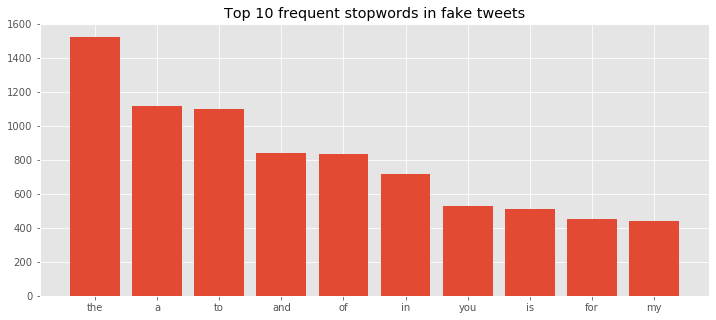

In [10]:
# Top 10 frequent stopwords in fake tweets
corpus0 = create_corpus(train,0)

dic0 = defaultdict(int)
for word in corpus0:
    if word in stop:
        dic0[word] += 1

top_words0 = sorted(dic0.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot the top 10 frequent stopwords in fake tweets
plt.figure(figsize=(12,5))
wd, cnt = zip(*top_words0)
plt.title('Top 10 frequent stopwords in fake tweets')
plt.bar(wd, cnt);

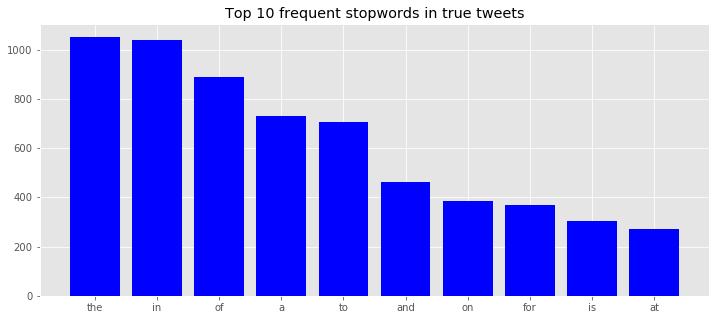

In [11]:
# Top 10 frequent stopwords in true tweets
corpus1 = create_corpus(train, 1)

dic1 = defaultdict(int)
for word in corpus1:
    if word in stop:
        dic1[word] += 1

top_words1 = sorted(dic1.items(), key=lambda x:x[1], reverse=True)[:10]

plt.figure(figsize=(12,5))
wd, cnt = zip(*top_words1)
plt.title('Top 10 frequent stopwords in true tweets')
plt.bar(wd, cnt, color='blue');

#### Analysis of stopwords in fake or true tweets:
- 'The' is the most frequent stopword in both class. 
- 'a','to', 'and' are the following most frequent stopwords in class 0; 
- 'in', 'of', 'a' are the following most frequent stopwords in class 1.

### (5) Punctuations in tweets

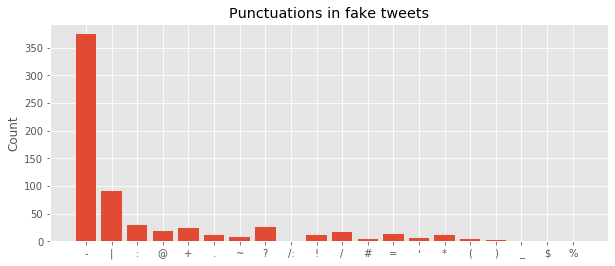

In [12]:
# Punctuation analysis for fake tweets
dic0 = defaultdict(int)
punc = string.punctuation

for item in corpus0:
    if item in punc:
        dic0[item] += 1

plt.figure(figsize=(10,4))
x, y = zip(*dic0.items())
plt.title('Punctuations in fake tweets')
plt.ylabel('Count')
plt.bar(x, y);

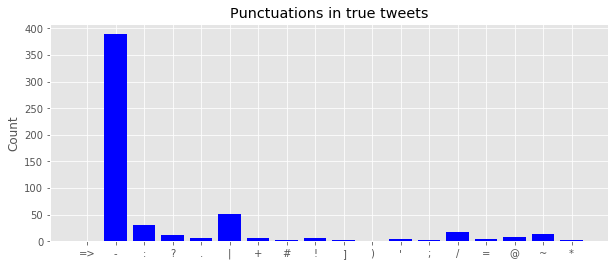

In [13]:
# Punctuation analysis for class 1
dic1 = defaultdict(int)
punc = string.punctuation

for item in corpus1:
    if item in punc:
        dic1[item] += 1

plt.figure(figsize=(10,4))
x, y = zip(*dic1.items())
plt.title('Punctuations in true tweets')
plt.ylabel('Count')
plt.bar(x, y, color='blue');

There is one thing we need to notice: when we create corpus, we split on ' '(white space) rather than '', thus the result count represents the counts of punctuations split by ' '.

### (6) Frequent words in tweets

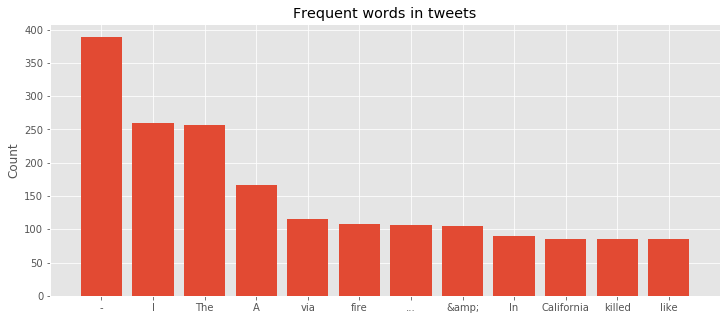

In [14]:
counter = Counter(corpus1)
common = counter.most_common()

x = []
y = []
for word, cnt in common[:40]:
    if word not in stop:
        x.append(word)
        y.append(cnt)

plt.figure(figsize=(12,5))
plt.title('Frequent words in tweets')
plt.ylabel('Count')
plt.bar(x, y);

#### Analysis of frequent words in tweets:
We can see that frequent words are dominated by punctuations and stop words because of white space and letter case. Raw data are very messy and we need to do cleaning work.

### (7) Bi-gram Analysis

In [15]:
# Define a function to get frequent bi-grams
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

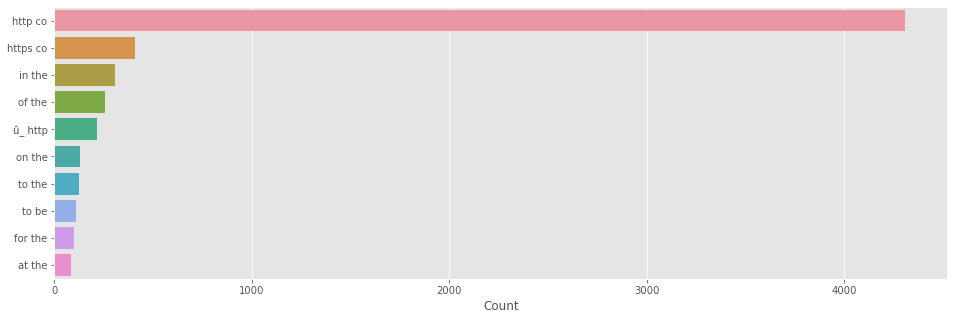

In [16]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
plt.xlabel('Count')
sns.barplot(x=y,y=x);

## 4. Data Cleaning

In [17]:
# Cleansing on the training data and testing data
df = pd.concat([train, test], sort=True)

### (1) Remove URL

In [18]:
# Define a function to remove URL
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Test function
test = 'Address of this kernel: https://www.kaggle.com/lilstarboy/kernel4d04fe5667/edit'
print(remove_url(test))

Address of this kernel: 


In [19]:
# Apply the function on 'text' column
df['text'] = df['text'].apply(remove_url)

### (2) Remove html tag

In [20]:
# Define a function to remove html tag
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

# Test function
test = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""
print(remove_html(test))


Real or Fake
Kaggle 
getting started



In [21]:
# Apply the function on 'text' column
df['text'] = df['text'].apply(remove_html)

### (3) Romove emojis

In [22]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

# Define a function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("To test 🚀")

'To test '

In [23]:
# Apply the function on 'text' column
df['text'] = df['text'].apply(remove_emoji)

### (4) Remove punctuations

In [24]:
# Define a function to remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

# Test function
test = 'This is very complex!!!!!??'
print(remove_punct(test))

This is very complex


In [25]:
# Apply the function on 'text' column
df['text'] = df['text'].apply(remove_punct)

## 5. Word Cloud

### (1) Word cloud for not disaster tweets

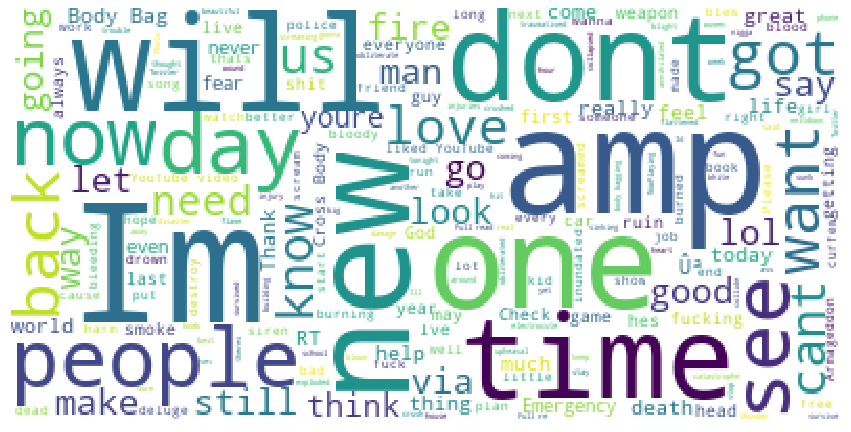

In [26]:
# Wordcloud for not disaster tweets
corpus_all_0 = create_corpus(df, 0)

# Plot the wordcloud
plt.figure(figsize=(15,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_all_0))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### (2) Word cloud for disaster tweets

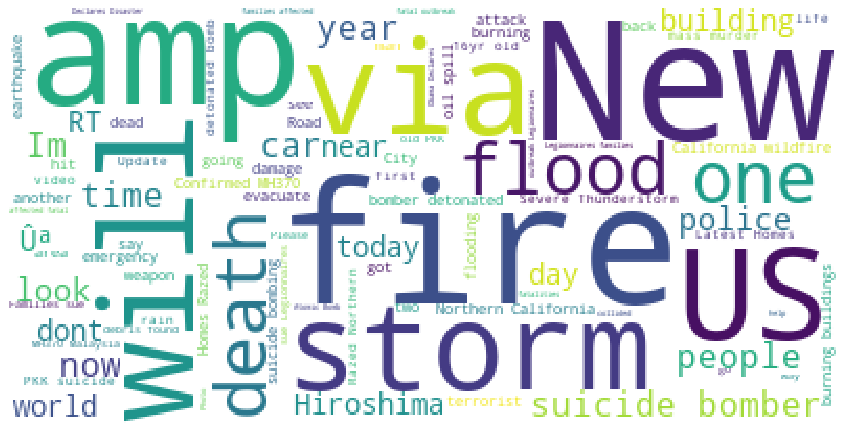

In [27]:
# Wordcloud for disaster tweets
corpus_all_1 = create_corpus(df, 1)

# Plot the wordcloud
plt.figure(figsize=(15,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_all_1))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## 6. Word Embeddings

### (1) Bag of words
In order to explore more visualizations, we convert the texts to vectors so as to capture the semantics in the texts.

The bag of words approach counts 1 if the word appears in the tweet, otherwise, counts 0.  We leverage the CountVectorizer to help lowercase, tokenize, omit words less than 2 characters, remove symbols, and then count the occurence of each token in each tweet.

In [28]:
# Define a function to return both the embedding matrix and CountVectorizer.
def cv(train_data):
    count_vectorizer = CountVectorizer(analyzer='word', stop_words = ['English']) # instantiate CountVectorizer object to convert text to matrix of token counts
    count_vectorizer.fit(train_data) 
    train_emb = count_vectorizer.transform(train_data) 
    return train_emb, count_vectorizer

# Test case
list_corpus = df["text"].tolist() 
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=42)

X_train_counts, count_vectorizer = cv(X_train) 
X_test_counts = count_vectorizer.transform(X_test)
print('Pass')

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['english'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pass


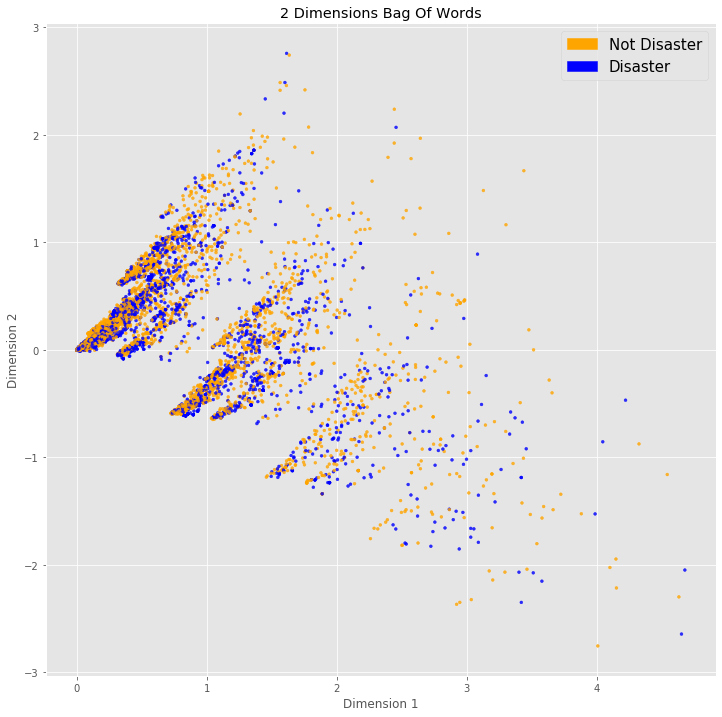

In [29]:
# Define plot_LSA function
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2) # reduce dimensions
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not Disaster')
            blue_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 15})

# Plot the BOW embeddings
fig = plt.figure(figsize=(12, 12))          
plot_LSA(X_train_counts, y_train)
plt.ylabel("Dimension 2")
plt.xlabel("Dimension 1")
plt.title('2 Dimensions Bag Of Words')
plt.show()

#### Anaylsis of BOW embeddings:
The non-disaster is a little sparser, and distribute more to the upperright. However, overall, We see that the non-disaster tweets and real disaster tweets are very similar on this BOW vector space. 

### (2) TFIDF
We use TF-IDF to take into account the importance(common in a tweets but rarer in the corpus) of the term in the corpus and weight the word frequency. 

In [30]:
# Define a function to return both the TFIDF matrix and CountVectorizer.
def tfidf(train_data):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(train_data)
    train_tfidf = tfidf_vectorizer.transform(train_data)
    return train_tfidf, tfidf_vectorizer

#Test case
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print('Pass')

Pass


We would like to see whether the tokens are similar or different from each other, or are there any interesting clusters, so we reduce high dimensioned tfidf word embeddings into 2D, and then plot them. 

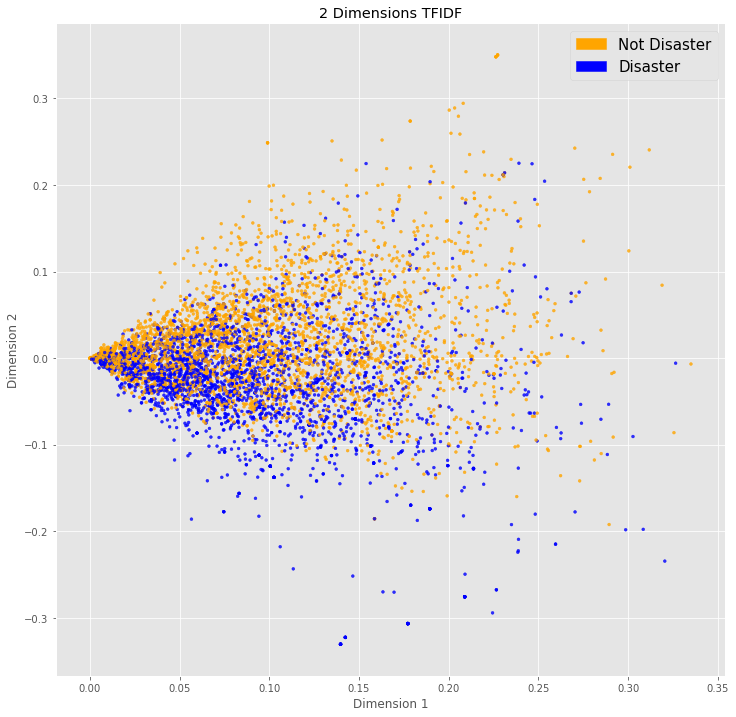

In [31]:
fig = plt.figure(figsize=(12, 12))          
plot_LSA(X_train_tfidf, y_train)
plt.ylabel("Dimension 2")
plt.xlabel("Dimension 1")
plt.title('2 Dimensions TFIDF')
plt.show()

We can see that tfidf seems so capture a bit more of the context of non-disaster and disaster tweets because we can now see some difference between the two groups on the vector space.

In [32]:
clusters = cluster.MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(X_test_tfidf)

# Define a function to get 10 frequent words for each cluster
def cluster_keys(x, clusters, labels, n_terms):
    df = pd.DataFrame(x.todense()).groupby(clusters).mean()
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
cluster_keys(X_test_tfidf, clusters, tfidf_vectorizer.get_feature_names(), 10)


Cluster 0
handbags,leather,womens,tote,what,shoulder,bagging,bag,cross,body

Cluster 1
disaster,in,of,video,is,to,and,the,new,for

Cluster 2
horror,nearby,appears,neighbours,unconfirmed,lives,saved,of,derailment,train

Cluster 3
with,at,in,is,by,on,and,to,of,the

Cluster 4
bleeding,and,the,army,for,fan,pick,im,is,my

Cluster 5
bayelsa,jonathan,hijacking,in,bioterror,fedex,longer,via,no,to

Cluster 6
me,do,can,are,have,and,to,your,the,you

Cluster 7
homes,reddit,razed,by,latest,northern,wildfire,california,than,more

Cluster 8
by,swallowed,airport,up,the,get,in,to,is,this

Cluster 9
volcano,of,usgs,hawaii,5km,eq,utc20150805,time20150806,19,earthquake

Cluster 10
that,dundee,shouldve,the,water,and,twister,ill,he,him

Cluster 11
but,that,and,was,suicide,so,fire,to,it,in

Cluster 12
med,correction,bodies,picking,tent,searching,rescuers,hundreds,boat,migrants

Cluster 13
is,natural,and,to,disaster,it,the,looks,that,like


## 7. Define Functions
In this part, we define functions to be applied on the final dataset.

In [33]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

# Define a function to remove links, non-ASCII characters and URLs
def clean_tweets(tweet):
    tweet = ''.join([x for x in tweet if x in string.printable])
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

In [34]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

# Define a function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [35]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

# Define a function to remove punctuations
def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [36]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

# Define a function to convert abbreviations to text
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

## 8. Build Bert Model

In [37]:
# Load data
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [38]:
# Clean data using defined functions
train["text"] = train["text"].apply(lambda x: clean_tweets(x))
test["text"] = test["text"].apply(lambda x: clean_tweets(x))
    
train["text"] = train["text"].apply(lambda x: remove_emoji(x))
test["text"] = test["text"].apply(lambda x: remove_emoji(x))
    
train["text"] = train["text"].apply(lambda x: remove_punctuations(x))
test["text"] = test["text"].apply(lambda x: remove_punctuations(x))
    
train["text"] = train["text"].apply(lambda x: convert_abbrev_in_text(x))
test["text"] = test["text"].apply(lambda x: convert_abbrev_in_text(x))

In [39]:
# Define hyperparameters
MAXLEN = 128
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 3e-6

In [40]:
# Import bert tokenizer, config and model
tokenizer = BertTokenizer.from_pretrained("https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt")
config = BertConfig.from_pretrained("https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json")
bert_model = TFBertModel.from_pretrained("https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-tf_model.h5",config=config)

In [41]:
# Convert the first sentence in 'text' column into word vector
text = train['text'][0]
print(text)
input_ids = tokenizer.encode(text,max_length=MAXLEN)
print(input_ids)
print(tokenizer.convert_ids_to_tokens(input_ids))

Our Deeds are the Reason of this # earthquake May ALLAH Forgive us all
[101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102]
['[CLS]', 'our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all', '[SEP]']


In [42]:
# Build input values on the training data
train_input_ids = []
train_attension_mask = []
train_token_type_ids = []
for text in train['text']:
    input_ids = tokenizer.encode(text,max_length=MAXLEN)
    padding_length = MAXLEN-len(input_ids)
    train_input_ids.append(input_ids+[0]*padding_length)
    train_attension_mask.append([1]*len(input_ids)+[0]*padding_length)
    train_token_type_ids.append([0]*MAXLEN)
train_input_ids = np.array(train_input_ids)
train_attension_mask = np.array(train_attension_mask)
train_token_type_ids = np.array(train_token_type_ids)

In [43]:
# Build input values on the testing data
test_input_ids = []
test_attension_mask = []
test_token_type_ids = []
for text in test['text']:
    input_ids = tokenizer.encode(text,max_length=MAXLEN)
    padding_length = MAXLEN-len(input_ids)
    test_input_ids.append(input_ids+[0]*padding_length)
    test_attension_mask.append([1]*len(input_ids)+[0]*padding_length)
    test_token_type_ids.append([0]*MAXLEN)
test_input_ids = np.array(test_input_ids)
test_attension_mask = np.array(test_attension_mask)
test_token_type_ids = np.array(test_token_type_ids)

In [44]:
y_train = np.array(train['target'])

In [45]:
# Build the Bert-base-Uncased model
input_ids = keras.layers.Input(shape=(MAXLEN,),dtype='int32')
attension_mask = keras.layers.Input(shape=(MAXLEN,),dtype='int32')
token_type_ids = keras.layers.Input(shape=(MAXLEN,),dtype='int32')
_, x = bert_model([input_ids,attension_mask,token_type_ids])
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.models.Model(inputs=[input_ids,attension_mask,token_type_ids],outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=LEARNING_RATE),metrics=['accuracy'])

In [46]:
# Fit the Bert-base-Uncased model
(train_input_ids,valid_input_ids,
 train_attension_mask,valid_attension_mask,
 train_token_type_ids,valid_token_type_ids,y_train,y_valid) = train_test_split(train_input_ids,train_attension_mask,
                                                               train_token_type_ids,y_train,test_size=0.1,
                                                               stratify=y_train, random_state=0)
early_stopping = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
model.fit([train_input_ids,train_attension_mask,train_token_type_ids],y_train,
         validation_data=([valid_input_ids,valid_attension_mask,valid_token_type_ids],y_valid),
         batch_size = BATCH_SIZE,epochs=NUM_EPOCHS,callbacks=[early_stopping])

Train on 6851 samples, validate on 762 samples
Epoch 1/5
6851/6851 [==============================] - 124s 18ms/sample - loss: 0.5480 - accuracy: 0.7241 - val_loss: 0.4228 - val_accuracy: 0.8202
Epoch 2/5
6851/6851 [==============================] - 106s 15ms/sample - loss: 0.3990 - accuracy: 0.8330 - val_loss: 0.3986 - val_accuracy: 0.8360
Epoch 3/5
6851/6851 [==============================] - 106s 15ms/sample - loss: 0.3565 - accuracy: 0.8492 - val_loss: 0.3904 - val_accuracy: 0.8425
Epoch 4/5
6851/6851 [==============================] - 106s 15ms/sample - loss: 0.3257 - accuracy: 0.8682 - val_loss: 0.3998 - val_accuracy: 0.8333
Epoch 5/5
6851/6851 [==============================] - 105s 15ms/sample - loss: 0.3011 - accuracy: 0.8826 - val_loss: 0.3987 - val_accuracy: 0.8360


In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

In [48]:
# Use the model to do prediction
y_pred = model.predict([test_input_ids,test_attension_mask,test_token_type_ids],batch_size=BATCH_SIZE,verbose=1).ravel()
y_pred = (y_pred>=0.5).astype(int)

3263/3263 [==============================] - 20s 6ms/sample


In [49]:
# Export to submission
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
submission['target'] = y_pred
submission.to_csv('nlp_prediction.csv',index=False)